In [1]:
import torch
import torch.nn as nn
import math
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale
import time

In [2]:
directories = [0, 1, 2, 3]

device = torch.device('cuda:0')
dtype = torch.float32

def read_all_image_folders(directories):
    images_150, images_300 = [], []
    for ix in directories:
        directory = f"../data/CAT_0{ix}/x1"
        for filename in os.listdir(directory):
            if filename.endswith(".jpg"):
                image = imageio.imread(f'{directory}/{filename}')
                images_300.append(scale_image(image, 1))        
                images_150.append(scale_image(image, 0.5))
    return images_150, images_300

In [3]:
def scale_image(image, scale):
    image = rescale(image=image, scale=scale, multichannel=True, anti_aliasing=True) 
    return image

In [4]:
data_150, data_300 = read_all_image_folders(directories)

/home/alex/.conda/envs/super-scaler/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


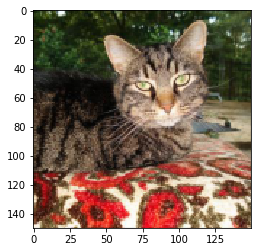

In [5]:
plt.imshow(data_150[0], interpolation='none')
plt.show()

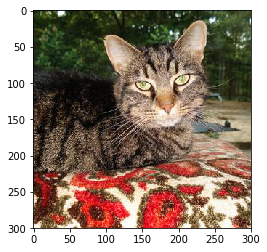

In [6]:
plt.imshow(data_300[0], interpolation='none')
plt.show()

In [7]:
x = torch.tensor(data_150, device = device, dtype = dtype)
y = torch.tensor(data_300, device = device, dtype = dtype)

In [8]:
# params

learning_rate = 0.001
batch_size = 32
epochs = 2000

# Regularisierung
weight_decay = 0.001

In [9]:
# Neural Network
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 9, stride = 1, padding = 4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size = 9, stride = 2, padding = 4, output_padding = 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
model = autoencoder().cuda()

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

In [12]:
# Train
loss_hist = []
psnr_hist = []
start = time.time()

for t in range(epochs):
    for batch in range(0, int(x.shape[0]/batch_size)):
            
        # Berechne den Batch
        batch_x = x[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        batch_y = y[batch * batch_size : (batch + 1) * batch_size, :].transpose(1, 3)
        
        # Berechne die Vorhersage (foward step)
        outputs = model.forward(batch_x)

        # Berechne den Fehler
        loss = criterion(outputs, batch_y)
        psnr = 10 * math.log10(1 / loss.item())
        
        # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Berechne den Fehler (Ausgabe des Fehlers alle x Iterationen)
    if t % 10 == 0:
        loss_hist.append(loss.item())
        psnr_hist.append(psnr)
        print(t, f"PSNR: {psnr}, MSE: {loss.item()}, Time: {time.time() - start}")
print('----------')
print(f'Full Time: {time.time() - start}')

0 PSNR: 23.367679149076054, MSE: 0.004605025984346867, Time: 12.989736318588257
10 PSNR: 23.740769149105624, MSE: 0.004225937649607658, Time: 118.89115619659424
20 PSNR: 23.521649439167973, MSE: 0.004444624297320843, Time: 223.19836902618408
30 PSNR: 23.491198988006893, MSE: 0.004475897178053856, Time: 327.5144076347351
40 PSNR: 23.505526152992008, MSE: 0.004461155738681555, Time: 432.43964743614197
50 PSNR: 23.86739327755747, MSE: 0.004104503896087408, Time: 536.6638233661652
60 PSNR: 23.88063292011115, MSE: 0.004092010203748941, Time: 640.9498841762543
70 PSNR: 23.90641699804052, MSE: 0.004067787900567055, Time: 745.2174682617188
80 PSNR: 23.898529265113634, MSE: 0.004075182601809502, Time: 849.5017368793488
90 PSNR: 23.9006120623246, MSE: 0.004073228687047958, Time: 953.7751588821411
100 PSNR: 23.900817119965385, MSE: 0.0040730363689363, Time: 1058.0672018527985
110 PSNR: 23.88725800836534, MSE: 0.004085772670805454, Time: 1162.1860427856445
120 PSNR: 23.66620851087597, MSE: 0.00429

1020 PSNR: 23.882375879189425, MSE: 0.004090368282049894, Time: 14181.805605649948
1030 PSNR: 23.875341103781977, MSE: 0.0040969992987811565, Time: 14373.130039453506
1040 PSNR: 23.88956122669667, MSE: 0.004083606414496899, Time: 14564.435101747513
1050 PSNR: 23.879243404032884, MSE: 0.004093319643288851, Time: 14755.743773460388
1060 PSNR: 23.890037172775486, MSE: 0.004083158913999796, Time: 14946.984989404678
1070 PSNR: 23.881917580249564, MSE: 0.004090799950063229, Time: 15138.146835565567
1080 PSNR: 23.873405082800726, MSE: 0.004098826088011265, Time: 15329.246641635895
1090 PSNR: 23.88681552633212, MSE: 0.004086188971996307, Time: 15520.335405349731
1100 PSNR: 23.888297573052256, MSE: 0.004084794782102108, Time: 15711.418397426605
1110 PSNR: 23.887922311003386, MSE: 0.004085147753357887, Time: 15902.487975120544
1120 PSNR: 23.891564910901806, MSE: 0.004081722814589739, Time: 16093.769565343857
1130 PSNR: 23.881650632283574, MSE: 0.004091051407158375, Time: 16285.081865787506
1140 

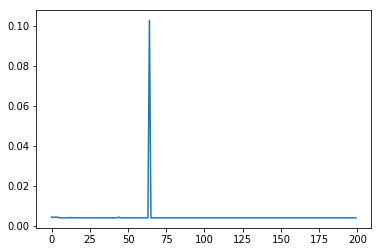

In [13]:
plt.plot(loss_hist)

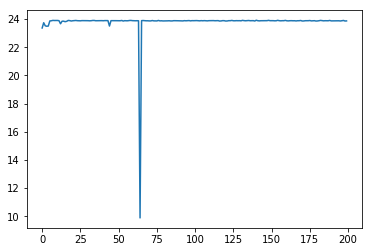

In [14]:
plt.plot(psnr_hist)

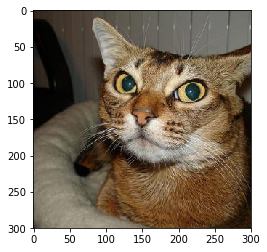

In [15]:
image = imageio.imread(f'../data/CAT_00/x1/00000001_020.jpg')
plt.imshow(image)
plt.show()

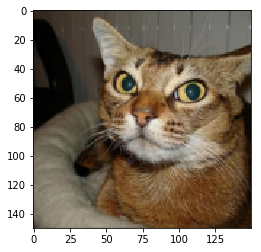

In [16]:
image_down = rescale(image=image, scale=0.5, multichannel=True, anti_aliasing=True).reshape(1, 150, 150, 3)
plt.imshow(image_down.reshape(150,150,3))
plt.show()

In [17]:
image_up = model.forward(torch.tensor(image_down, dtype = dtype, device = device).transpose(1, 3))

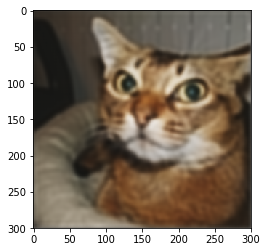

In [18]:
plt.imshow(image_up.transpose(1,3).cpu().detach().numpy().reshape(300, 300, 3))
plt.show()

In [19]:
torch.save(model.cpu(), f'../data/models/x2_{psnr}.pt')

/home/alex/.local/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
